# The Impact of School Closings on the Spread of Influenza in South Hadley
Authors: Ling Gan & Moira Crawshaw  
Fall 2019  
Professor Valerie Barr, COMSC-243MS  


## Abstract

There have been continuous efforts of reducing contact between people during influenza seasons in order to control the disease. We used stock and flow model to simulate a flu spread among the sample dataset of the population distribution in zip code area 01075, which includes South Hadley, Granby, and Holyoke, MA. We try to measure the effectiveness and efficacy of school closing in constraining the flu. Our finding indicates that school closing would not have significant effects in terms of reducing the total infected population. More specifically, although the closing of schools in the early stage of flu spread and the extension of the length of school closing does decrease the total infected population, the change is negligible in terms of the total percentage (about 0.5%). 


### Figure 1. 

The percent of the total population infected depending on the number of days school is closed for.  Each line represents a different start day.  The longest school closure (35 days) and earliest start day (0) result in the lowest percent infected ( ~13.9%).  Notice that the y-axis ranges only from 0.139 to 0.144.

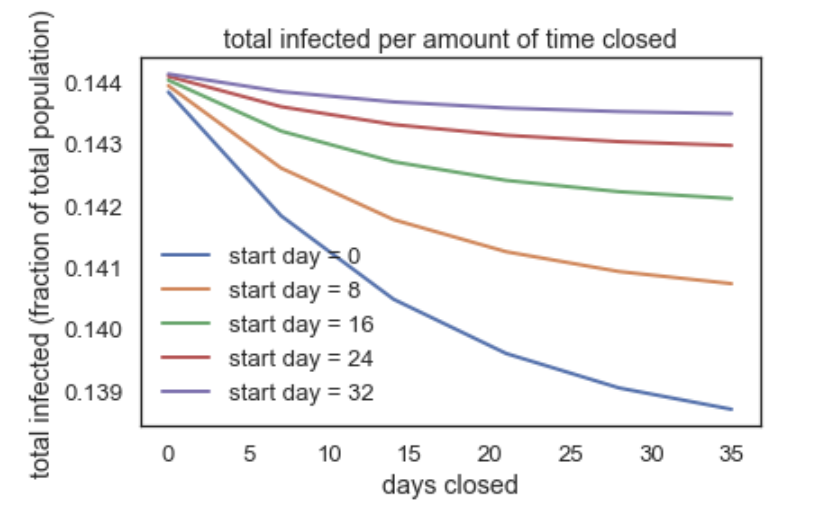

### Figure 2.

Susceptible, infected, and recovered of both control group and maximum intervention group (close on day zero, closed for 35 days) over time.  The lines are barely distinguishable because school closing makes a very negligible difference.

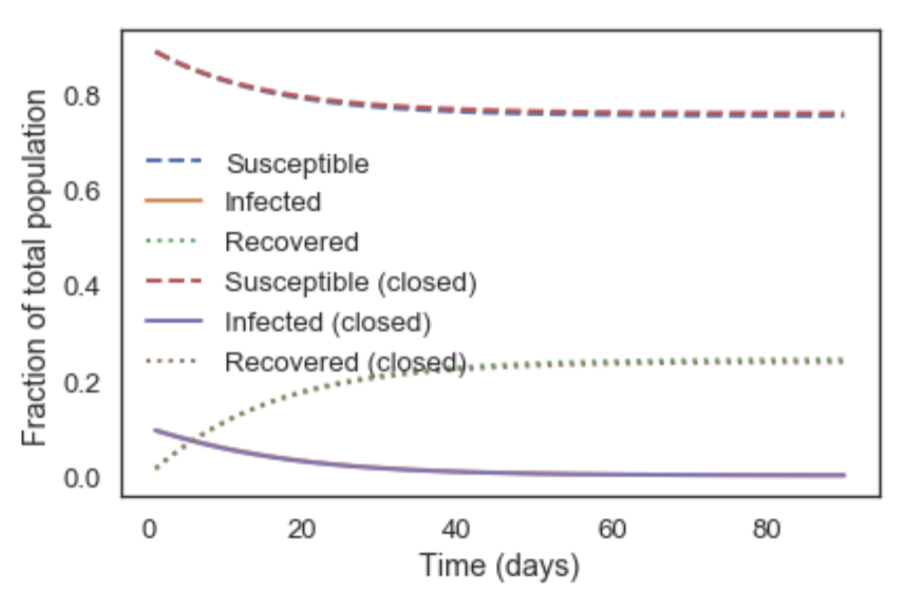

## Question 1:

Can we model the spread of influenza in the zip code area 01075 with an SIR model that introduces heterogeneity of age into each stock?  What initial infection rate produces a probable model based on existing estimates of flu infection?


## Model 1:

We based our initial model of the SIR model from the textbook. Instead of having only three stocks -- one for susceptible, one for infected, and one for recovered -- we had twelve: an S, I, and R for each of four age groups.  

The breakdown of age groups was based on data from the 2010 from the census for zip code 01075 (4).  The four groups were: 0-4 years, 5-18 years, 19-64 years, and 65 years or greater.  Those in each age group interacted with each of the other groups as well as others in their own group for the same amount of time each day.  

To estimate the effect of one group on another, we obtained values from Haber et al. (2).  This paper modelled flu spread in a small urban community, and estimated transmission rates mathematically from existing data.  Transmission rates (lambda) are defined as  the “rate of viral transmission per minute of contact from an infected person” in one group to a person another group.  We used these estimated rates.  The probability that transmission occurred from an individual in group i to an individual in group j during a contact of d minutes was 1 – exp {–(lambda)ijd} (2).  We kept d constant for this first model at 120 minutes, which was averaged from the duration that this paper used.  

We set the length of flu season, i.e. the number of time steps, to 90 days, as according to the CDC flu season occurs from mid October to February (7).

According to the CDC, one infected with influenza is contagious for about 1 day before symptoms show and 5-7 days after (6).  We therefore set the recovery time to an average of 7 days,  because we assume that anyone infected will recover and not die, so for the sake of the model if one is not contagious they are recovered.


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *
import math

In [2]:
#Most people who get flu will recover in an average of 7 day (source 1)
RECOVERY_TIME = 7
GAMMA= 1/RECOVERY_TIME

#the duration of contact varies between different ages groups but the 
#average is around 240 mins (source 2)
DURATION = 240

#the number of population in different four different age groups in
#South Hadley (source 3)

#0-4
POP0_4 = 783
#5-18
POP5_18 = 1969
#19-64
POP19_64 = 9858
#64 and above
POP64 = 2996

#total number of population in South Hadley
TOTAL_POP = POP0_4 + POP5_18 + POP19_64 + POP64

#strata of different age groups in percentage of the grand total 
STRATA1 = POP0_4 / TOTAL_POP
STRATA2 = POP5_18 / TOTAL_POP
STRATA3 = POP19_64 / TOTAL_POP
STRATA4 = POP64 / TOTAL_POP

#array of transmission rates from one specific group to all other 
#groups (source 2)

# in the order ot 0-4 age, 5-18 age, 19-64 age, 64- age 
#for example, LAMBDA_ARRAY0_4[0] denotes the transmission rate from 
#0-4 age group to 0-4 age group

LAMBDA_ARRAY0_4 = [0.00059, 0.00058, 0.00057, 0.00057]
LAMBDA_ARRAY5_18 = [0.00062, 0.00061, 0.00053, 0.00054]
LAMBDA_ARRAY19_64 = [0.00033, 0.00033, 0.00032, 0.00029]
LAMBDA_ARRAY64 = [0.00080, 0.00080, 0.00080, 0.00102]



[0.0008, 0.0008, 0.0008, 0.00102]

In [3]:
def make_system(ageGroupFraction, lamda_array, gamma, 
                i_initial):
    #must spell "lamda" bc lambda is a keyword in python
    """Make a system object for the SIR model.
    
    ageGroupFraction: the precentage of certain age group in respect to
                        the total population
    lamda_array: array of tramission rate in days
    gamma: recovery rate in days
    i_initial: the portion of inital infected population 
    
    returns: System object
    """
    
    init = State(S=ageGroupFraction*(1-i_initial),
                 I=ageGroupFraction*i_initial , R=0)
    t0 = 0
    
    #peak of flu season is about 3 months (source 2)
    t_end = 3*30

    return System(init=init, t0=t0, t_end=t_end, 
                  lamda_array = lamda_array, gamma=gamma)

In [1]:
def update_func(index, state_array, system, t, closed):
    """Update the SIR model for the age of in the given index
    
    index: which age group's state we are updating
    state_array: State (s, i, r) for all age groups
    system: System object
    t: time
    closed: a boolean to determine if school closing 
            intervention is applied
    
    returns: State (SIR)
    """
    
    lamda_array, gamma = system.lamda_array,system.gamma
    #create a beta_array for the infectious rate calculated based on
    #the contact rate between a suspcitable strata and a infectious strata
    #and the duration of contact
    beta_array = []
    
    for j in range(len(lamda_array)):
        #if closes school, the the duration of contact between age group 5-18 
        #to age group 5-18 is zero
        #else duration remains unchange
        if(closed and j == 1 ):
            beta = 1-math.exp(-lamda_array[j]*0)
        else: 
            beta = 1-math.exp(-lamda_array[j]*DURATION)
        beta_array.append(beta)
    
    #the current state of SIR for the specified group 
    s, i, r = state_array[index]
    
    #the number of infected in this timestep
    infected = 0
    
    #calculate the infected population and recovered population
    for k in range(len(state_array)):
        infected += beta_array[k]*s*state_array[k].I
    
    recovered = gamma * i
    
    #update SIR 
    s -= infected
    i += infected - recovered
    r += recovered
    

    return State(S=s, I=i, R=r)

In [5]:
def update_all(state_array, system_array, t, closed):
    """based on the state in state array, it calls the update function based 
        on the corresponding system i in the system array for t timestep
        
    state_array: storing the four age groups states of SIR 
    system_array: holds the four age groups inital states and the lamda array
                 of contact rates with three other groups
    t: the time step
    closed: a boolean to determine if school closing intervention is applied
    
    returns: the updated states 
    """
    
    #a state array to store the updated states 
    state_updated = []
    
    #for each strata update its SIR 
    for index in range(len(state_array)):
        
        #only age group 5-18's infected activity is influenced by school closing
        if(index == 1):
            result = update_func(index, state_array, system_array[index], 
                                 t, closed)
        else: 
            result = update_func(index, state_array, system_array[index],
                                 t, False)
            
        state_updated.append(result)
        
    return state_updated
    

In [6]:
def run_simulation(system_array, update_func, close_length, close_start):
    """Runs a simulation of the system.
        
    system_array: array of System object for each age groups 
    update_func: function that updates state
    close_length: the length of school closing
    close_start: the timestep when the school closing starts
    
    returns: TimeFrame array 
    """
    #stores all the states of different age groups
    state_array = []
    
    #stores all the timeframes of different age groups
    time_frame_array = []
    
    #make inital states and inital timeframes for each system
    for k in range(len(system_array)):
        init = system_array[k].init
        state_array.append(init)
        time_frame_array.append(TimeFrame(columns = init.index))
    
    #get the flu time span 
    t0, t_end = system_array[0].t0, system_array[0].t_end
    
    #store timestep of the end of school closing 
    closed_end = 0
    
    #boolean indicate if the school closing is applied or not
    closed = False
    
    #run through time span
    for t in linrange(t0, t_end):
        if(t ==close_start):
            #closes the school
            closed = True
            closed_end = t+ close_length
            
        #the new state array for this time step
        next_state_array = update_all(state_array, system_array, t, closed)
        
        #store the states to the corresponding timeframe for this timestep
        for j in range(len(time_frame_array)):
            time_frame_array[j].row[t+1] = next_state_array[j]
        
        #update the state array
        state_array = next_state_array
        
        #reopen the school
        if(t == closed_end):
            closed = False
            
    return time_frame_array
    

In [7]:
def calc_total_infected(results_array,inital_infected):
    """Calculate the fraction of population infected for 
        the total population during the simulation.
    
    results_array: DataFrame with columns S, I, R for 
                    different age groups 
    inital_infected: the inital infected percentage 
    
    returns: fraction of population
    """
    #stores the final susceptible percentage of the total population 
    final_susceptible = 0
    
    #calculate the sum of all age group's susceptible percentage  
    for frame in results_array:
        final_susceptible += get_last_value(frame.S)
    
    #calculate the total infected population percentage 
    #I_INIT is the inital percentage of infected population
    total_infected = (1-inital_infected)-final_susceptible
    
    return total_infected
    

In [8]:
def calc_each_total_infected(results_array,inital_infected):
    """Calculate the fraction of population infected 
        for each age group during the simulation.
    
    results_array: DataFrame with columns S, I, R 
                    for different age groups 
    inital_infected: the inital infected percentage 

    
    returns: fraction of population
    """
    infected = TimeSeries()
    
    #calcualte the infected population for each age groups
    for i in range(len(results_array)):
        
        total_infected = get_first_value(results_array[i].S) -
        get_last_value(results_array[i].S)
        
        total = get_first_value(results_array[i].S)+ 
        get_first_value(results_array[i].I)
        +get_first_value(results_array[i].R)
        
        infected[i]=total_infected/total
    
    return infected

In [9]:
def sweepInitialInfected(infected_array, update_func):
    
    """sweep the initial infected population without closing: 
    
    infected_array: an array of possible start infectious rate
    update_func: an update function 
    
    return: one sweep frame for infected population for each age 
            groups one for the one sweep series for the infected 
            population for the total  
    """    
    
    sweep_infectious = SweepFrame(columns = infected_array)
    sweep_infectious_total = SweepSeries()
    
    #sweep through all the inital infectious percentage
    for init in infected_array:
        
        #make four systems in total, each for an age group
        system1 = make_system(STRATA1, LAMBDA_ARRAY0_4, GAMMA, init)
        system2 = make_system(STRATA2, LAMBDA_ARRAY5_18, GAMMA, init)
        system3 = make_system(STRATA3, LAMBDA_ARRAY19_64, GAMMA, init)
        system4 = make_system(STRATA4, LAMBDA_ARRAY64, GAMMA, init)
        #put them into an array
        systems = [system1, system2, system3, system4]
        
        #set the closing length and the close start time to 0 and -1
        results_array = run_simulation(systems, update_func, 0, -1)
        sweep_infectious[init] = calc_each_total_infected(results_array,init)
        sweep_infectious_total[init] = calc_total_infected(results_array,init)
        
    return sweep_infectious,sweep_infectious_total
    

In [10]:
def sweepParam(closing_array, t_start_array, system_array, update_func, init_infectious):
    
    """sweep two parameters: closing length and start time of closing 
    
    closing_array: an array of possible closing length
    t_start_array: an array of possible start time of school closing
    system_array: an array of different systems for the age groups 
    update_func: an update function 
    init_infectious: a fraction of initial infectious population
    
    return: a sweep frame 
    """
    #create a sweepframe as closing length as column index 
    #and closing start time as row index
    sweep_frame = SweepFrame(columns=closing_array)
    
    #sweep two parameters 
    for length in closing_array:
        sweep_start = SweepSeries()
        
        for start in t_start_array:
            results_array = run_simulation(system_array, update_func,
                                           length, start)
            
            sweep_start[start] = calc_total_infected(results_array, 
                                                     init_infectious)
        sweep_frame[length] = sweep_start
   
    return sweep_frame
    

In [11]:
def graph_sweep(frame, row_label):
    """this method graphs the given sweep frame with given labels
    
    frame: sweep frame
    row_label: row label of the frame

    """
    
    #graph each row of the frame
    for row in frame.index:
        label = row_label + " = " + str(row) 
        plot(frame.row[row], label=label)


In [27]:
def plot_results(S, I, R, group=""):
    """Plot the results of a SIR model.
    
    S: TimeSeries
    I: TimeSeries
    R: TimeSeries
    group: information for label
    
    """
    
    #plot the S,I,R 
    plot(S, '--', label='Susceptible '+ group)
    plot(I, '-', label='Infected '+group)
    plot(R, ':', label='Recovered '+group)
    decorate(xlabel='Time (days)',
             ylabel='Fraction of total population')

In [13]:
def calc_total_SIR(results_array):
    """this method calcuate the sum of the total SIR for frames array given 
    
    results_array: an timeframe array of different age groups
    
    return S_series, I_series, R_series
    
    """

    #make time series for the total S,I,R respectively
    S_series = TimeSeries()
    I_series = TimeSeries()
    R_series = TimeSeries()


    #for each timestep
    for row in results_array[0].index:

        totalS, totalI, totalR = 0, 0, 0
        
        #calculate the sum of S,I,R respectively
        for age_group in results_array:
            
            totalS += age_group.S[row]
            totalI += age_group.I[row]
            totalR += age_group.R[row]
        
        S_series[row] = totalS
        I_series[row] = totalI
        R_series[row] = totalR
        
    return S_series, I_series, R_series


According to the National Foundation for Infectious Diseases, about 5-20% of the U.S. population is infected by influenza every year (5).  We swept an initial infection rate (the same between age groups), to identify a likely initial infection rate that could result in this fraction for both the total population and within each age group. 


In [15]:
#sweep the initial infectious percentage of population each
#group first to detect a optimal disturbution
init_array = linrange(0.05,0.8,0.05 )
infected_sweep,infected_sweep_total =  sweepInitialInfected(init_array, update_func)

# Results 1

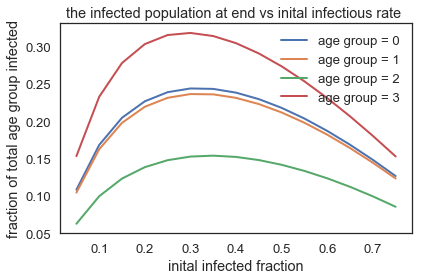

In [41]:
#plot the initial infection rate sweep  for each age group
graph_sweep(infected_sweep, "age group")
decorate(title = "the infected population vs inital infectious rate",
         xlabel='inital infected fraction',
         ylabel='fraction of total age group infected')

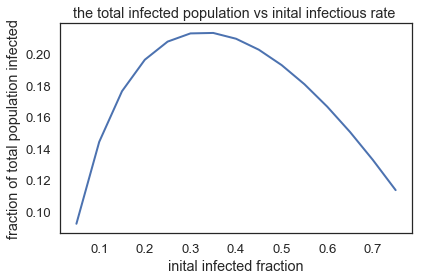

In [42]:
#plot the initial infection rate sweep for the total population
plot(infected_sweep_total)
decorate(title = "the total infected population vs inital infectious rate ",
         xlabel='inital infected fraction',
         ylabel='fraction of total population infected')

the lower and higher ends of the initial infection rates in our range result in a total infected fraction between 0.05 and 0.20.  In the middle the total infected fraction becomes very high.

# Interpretation 1

We choose 0.1 as our initial infection rate to use.  This is at the lower end of our arbitrarily determined intital sweep. It gives the following values:

when intitial infection rate is 0.1:

fraction of each age group infected:

0    0.168580

1    0.162815

2    0.099898

3    0.233085

Name: 0.1, dtype: float64 

fraction of total population infected:

 0.14418238940086814

In the 3rd age group (19-64) the result is over 20%.  However, we would like to see what might happen in an epidemic, so we choose a fraction on the high side.  

Different age groups probably have different intitial infection fractions.  Our entire model is based on the fact that there are different transmission probabilities between age groups.  However, this would require sweeping four parameters, which is not feasible.  This initial value for all groups should be good enough.

In [18]:
#initial fraction of population infected
#from the sweeping, 0.1 gives a reasonable total final infectious population
#resembles the real world
I_INIT = 0.1

0.1

In [19]:
#make four systems in total, each for an age group
system1 = make_system(STRATA1, LAMBDA_ARRAY0_4, GAMMA, I_INIT)
system2 = make_system(STRATA2, LAMBDA_ARRAY5_18, GAMMA, I_INIT)
system3 = make_system(STRATA3, LAMBDA_ARRAY19_64, GAMMA, I_INIT)
system4 = make_system(STRATA4, LAMBDA_ARRAY64, GAMMA, I_INIT)

#put them into an array
systems = [system1, system2, system3, system4]

[init           S    0.045156
 I    0.005017
 R    0.000000
 dtyp...
 t0                                                             0
 t_end                                                         90
 lamda_array                 [0.00059, 0.00058, 0.00057, 0.00057]
 gamma                                                   0.142857
 dtype: object, init           S    0.113552
 I    0.012617
 R    0.000000
 dtyp...
 t0                                                             0
 t_end                                                         90
 lamda_array                 [0.00062, 0.00061, 0.00053, 0.00054]
 gamma                                                   0.142857
 dtype: object, init           S    0.568512
 I    0.063168
 R    0.000000
 dtyp...
 t0                                                             0
 t_end                                                         90
 lamda_array                 [0.00033, 0.00033, 0.00032, 0.00029]
 gamma                               

## Question 2:
Does closing schools help diminish the spread of influenza during flu season? What combination of number of days closed and starting day to close the school minimizes the total fraction of the population that gets sick?


## Model 2:

We used the model from the first section, and modified the run simulation method to take into account the start day of school closing and number of closed days. 

 We modelled school closing by reducing the duration of contact between individuals of the 5-18 age group to zero minutes per day.  We assumed for simplicity that during this period 5-18 year olds had no contact with others in their age group but contact with other age groups remained normal otherwise.  

We swept 2 parameters -- start day and length of closing


In [ ]:
#sweep array for two parameters: closing length and start time of closing 
closing_array = linrange(0,42,7)
t_start_array = linrange(0, 40,8)

## Results 2:

In [21]:
#sweep both parameters together
frame = sweepParam(closing_array, t_start_array, systems, update_func,I_INIT)

,0,7,14,21,28,35
0,0.143834,0.141830,0.140476,0.139597,0.139040,0.138693
8,0.143936,0.142603,0.141766,0.141246,0.140925,0.140729
16,0.144026,0.143202,0.142704,0.142402,0.142219,0.142109
24,0.144088,0.143597,0.143307,0.143134,0.143030,0.142969
32,0.144127,0.143840,0.143673,0.143575,0.143517,0.143484



If we look at the graph of the sweep, it shows that the earlier the school closed and the longer it was closed for, the less of the total population was infected.  However this difference in total infected amounts to very little of the total population.  With no closings, the percent of the total population infected was about 14.4 %, and the percent of 5-19 year olds infected was about 16.3% (see model 1).  With the optimal closing length and start time the percent of total population infected was about 13.9%, a difference of 0.5%.


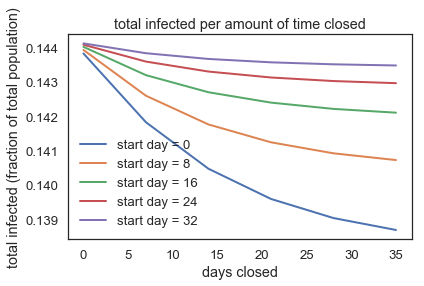

In [46]:
#graph the sweepframe 
graph_sweep(frame, "start day")
decorate(title='total infected per amount of time closed',xlabel='days closed',
         ylabel='total infected (fraction of total population)')

If we graph both the control and the combination of parameters that had the least percent infected over time, we see that the lines look almost identical.


In [ ]:
#for the sake of comparsion, run simulation of the model without closing 
#and the model with the most optimal closing length and start time

results_array = run_simulation(systems, update_func, 0, systems[0].t_end)
results_array_closed = run_simulation(systems, update_func, 35, 0)

In [ ]:
#calculate the SIR for the total population under two scenarios  
S_series,I_series, R_series = calc_total_SIR(results_array)
S_series_closed,I_series_closed, R_series_closed = calc_total_SIR(
    results_array_closed)

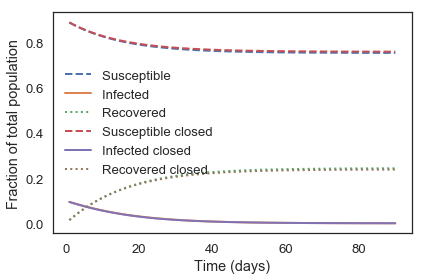

In [28]:
#plot them on the same graph
plot_results(S_series, I_series, R_series)
plot_results(S_series_closed, I_series_closed, R_series_closed, "closed")

## Interpretation 2:

Rather intuitively, our model shows that the earliest start day (day 0) and longest closing time (35 days) result in the lowest percentage infected. We conclude that closing school for any period does not have a meaningful impact on decreasing the percent of the total population that becomes infected (~0.5%).  School closings are not very practical solution to flu epidemic anyway, as school would definitely be less effective should we cancel it for an entire month to marginally decrease influenza spread.

Our simple model is supported by the more complicated model in the paper that we took our transmission rates from, as they also concluded that school closing was ineffective (2).

One important assumption we made that we attempted in the first model to reverse engineer the solution to is the infection rate at the “start” of the epidemic.  First of all, though flu infection peaks in December-February, it is active year round, so there isn’t a clear “end “ or “beginning” to the epidemic (7).  Secondly, we don’t know what that first “initial infection rate” is, so we are only setting a value for it by fitting our model to what we want it to be.  We used the same initial infection rate across every age group, an assumption which contradicts the question the model itself tries to answer, as we want to introduce differences between groups.  Since we recognize that we are not really starting at time zero, it is extremely likely that the "initial" infection rate be different in every group.

It was important to first establish a probable initial infection rate to design a meaningful model, before we attempted to solve a problem.  Once we had a model that matched estimates from the National Foundation for Infectious Diseases, we could then use it to determine whether a specific intervention would be effective.


## References Cited

(1) https://www.cdc.gov/flu/symptoms/symptoms.htm

(2) https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2725959/

(3) https://www.cdc.gov/flu/about/season/flu-season-2018-2019.htm

(4) https://factfinder.census.gov/faces/tableservices/jsf/pages/productview.xhtml?src=CF

(5) https://www.nfid.org/infectious-diseases/influenza-flu/

(6) https://www.cdc.gov/flu/about/disease/spread.htm

(7) https://www.cdc.gov/flu/about/season/flu-season.htm

